
----
# Cuaderno 13 - Proyecto completo
# Parte 2: Entrenamiento, evaluación y selección de modelos
## Ariel Palazzesi - 2026
----


En este cuaderno continuaremos con el proyecto iniciado en la entrega anterior. Ya realizamos el preprocesamiento completo del dataset clínico, construimos un pipeline robusto e identificamos la variable objetivo `enfermo`.

Ahora vamos a aplicar diferentes modelos de clasificación binaria sobre esos datos preparados, evaluar su rendimiento con métricas específicas y visualizaciones, y tomar una decisión informada sobre cuál modelo es más adecuado para este caso clínico.

In [ ]:
# Importamos librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn: modelos y herramientas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Cargamos el dataset (preprocesado en la clase anterior)
df = pd.read_csv("heart_disease_uci.csv")

# Usamos la misma selección de variables que en la clase 14
variables_numericas = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
variables_categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
columnas_a_utilizar = variables_numericas + variables_categoricas

# Cargamos también el pipeline construido anteriormente (aquí se asume que sigue disponible en memoria)
# Si no está disponible, se debería ejecutar nuevamente el código del pipeline

# Creamos la columna 'enfermo' a partir de 'num' (como hicimos en la Clase 14)
# (Esto debes hacerlo solo si no guardaste el dataset en la sesión anterior.)
df["enfermo"] = df["num"].apply(lambda x: 1 if x > 0 else 0)

# Definimos la variable objetivo
y = df["enfermo"]


## Preparación inicial de los datos

En esta primera sección retomamos el dataset clínico que ya habíamos trabajado antes. Como vimos entonces, la variable `num` representa el diagnóstico original del paciente, con valores de 0 a 4.

Para simplificar el problema y enfocarnos en una tarea de **clasificación binaria**, volvemos a crear la variable `enfermo`, donde:

- `0` indica que el paciente **no presenta** enfermedad cardíaca.
- `1` indica que el paciente **sí presenta** enfermedad cardíaca.

Esta será la variable objetivo (`y`) que utilizaremos para entrenar nuestros modelos. Las variables predictoras (`X`) serán las mismas que preprocesamos en el cuaderno anterior, utilizando un pipeline que incluía imputación, codificación y estandarización.

En los próximos pasos, aplicaremos ese pipeline a los datos, dividiremos el conjunto en entrenamiento y prueba, y comenzaremos con el entrenamiento de modelos supervisados.


In [ ]:
from sklearn.model_selection import train_test_split

# Aseguramos que el pipeline esté definido (debe ejecutarse si no quedó en memoria)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Redefinimos las variables
variables_numericas = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
variables_categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
columnas_a_utilizar = variables_numericas + variables_categoricas

# Pipeline numérico
pipeline_numerico = Pipeline([
    ('imputacion', SimpleImputer(strategy='mean')),
    ('escalado', StandardScaler())
])

# Pipeline categórico
pipeline_categorico = Pipeline([
    ('imputacion', SimpleImputer(strategy='most_frequent')),
    ('codificacion', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline combinado
preprocesador = ColumnTransformer([
    ('num', pipeline_numerico, variables_numericas),
    ('cat', pipeline_categorico, variables_categoricas)
])

# Aplicamos el preprocesador
X = preprocesador.fit_transform(df[columnas_a_utilizar])
y = df["enfermo"]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificamos tamaño
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")


Conjunto de entrenamiento: (736, 25)
Conjunto de prueba: (184, 25)


## División en entrenamiento y prueba

Aplicamos el pipeline de preprocesamiento a las variables predictoras, transformando correctamente el dataset original en una matriz de 25 columnas (combinando variables numéricas escaladas y categóricas codificadas).

Luego dividimos el conjunto en dos partes:

- **Conjunto de entrenamiento**: 736 registros (80%)
- **Conjunto de prueba**: 184 registros (20%)

Esta división es fundamental para evaluar de forma justa el rendimiento de los modelos: entrenamos con un subconjunto de datos, y luego medimos su capacidad de generalizar predicciones sobre ejemplos que nunca vio.

En las próximas celdas vamos a entrenar distintos modelos sobre `X_train` y `y_train`, y luego analizaremos su comportamiento sobre `X_test`.


In [ ]:
# Entrenamiento del modelo de Regresión Logística
modelo_logistico = LogisticRegression(max_iter=1000, random_state=42)
modelo_logistico.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred_log = modelo_logistico.predict(X_test)


## Modelo 1: Regresión Logística

Entrenamos un modelo de **Regresión Logística**, que es una técnica ampliamente utilizada en problemas de clasificación binaria, especialmente en contextos clínicos y sociales debido a su simplicidad, interpretabilidad y eficiencia.

Este modelo estima la probabilidad de que un caso pertenezca a la clase positiva (`enfermo = 1`), y luego aplica un umbral (por defecto, 0.5) para tomar la decisión final.

Ya generamos las predicciones sobre el conjunto de prueba (`y_pred_log`). En las próximas celdas, vamos a evaluar su rendimiento utilizando:

- Matriz de confusión
- Métricas de clasificación (accuracy, precision, recall, F1-score)
- Curva ROC

Estos elementos nos permitirán comprender cómo se comporta el modelo y qué tipo de errores comete.


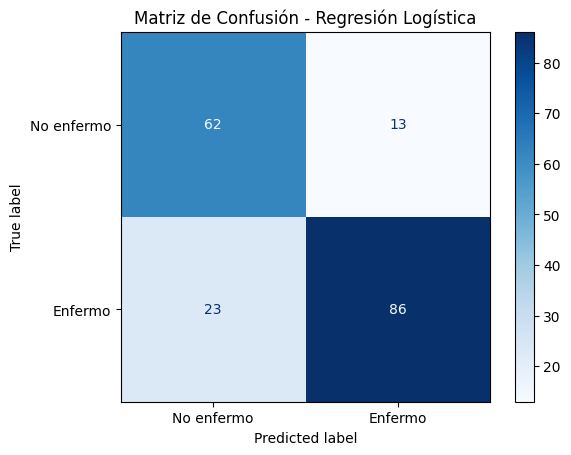

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculamos la matriz de confusión
matriz_log = confusion_matrix(y_test, y_pred_log)

# Mostramos la matriz con etiquetas legibles
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_log, display_labels=["No enfermo", "Enfermo"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


### Matriz de confusión:

La matriz de confusión nos permite observar cómo se comportó el modelo en términos de aciertos y errores:

- **62 verdaderos negativos**: pacientes correctamente clasificados como "no enfermos".
- **86 verdaderos positivos**: pacientes correctamente clasificados como "enfermos".
- **13 falsos positivos**: personas sin enfermedad que fueron clasificadas erróneamente como enfermas.
- **23 falsos negativos**: personas con enfermedad que el modelo no detectó.

Este último caso (falsos negativos) es especialmente delicado en contextos clínicos, ya que implica no detectar a tiempo un caso real. Por eso, aunque el modelo parece equilibrado, será importante observar también métricas como el **recall**, que nos indican qué tan bien está detectando los casos positivos.

En la siguiente celda vamos a calcular las métricas más importantes para este modelo, y analizaremos con más precisión su rendimiento general.


In [ ]:
from sklearn.metrics import classification_report

# Mostramos el reporte de métricas
reporte_log = classification_report(y_test, y_pred_log, target_names=["No enfermo", "Enfermo"])
print("Reporte de clasificación - Regresión Logística\n")
print(reporte_log)


Reporte de clasificación - Regresión Logística

              precision    recall  f1-score   support

  No enfermo       0.73      0.83      0.78        75
     Enfermo       0.87      0.79      0.83       109

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.81       184



### Métricas de evaluación: Regresión Logística

A partir del reporte de clasificación, podemos observar:

- **Accuracy general**: 0.80 → el 80% de las predicciones fueron correctas.
- **Precision (enfermo)**: 0.87 → cuando el modelo predice "enfermo", acierta el 87% de las veces.
- **Recall (enfermo)**: 0.79 → detecta correctamente el 79% de los casos verdaderamente enfermos.
- **F1-score (enfermo)**: 0.83 → buen equilibrio entre precisión y sensibilidad.

Aunque el modelo comete algunos errores, especialmente falsos negativos (como vimos en la matriz de confusión), su rendimiento general es robusto y balanceado entre clases.

Este modelo resulta prometedor, sobre todo por su **simplicidad e interpretabilidad**, lo cual es un valor añadido si el sistema debe ser utilizado por profesionales de la salud que necesitan entender cómo se toman las decisiones.

En la siguiente sección vamos a comparar estos resultados con los de otro modelo más complejo: el Random Forest.


In [ ]:
# Entrenamiento del modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred_rf = modelo_rf.predict(X_test)


## Modelo 2: Random Forest

Entrenamos un modelo de **Random Forest**, la técnica de ensamble basada en múltiples árboles de decisión. Este algoritmo combina el resultado de varios clasificadores independientes para mejorar la precisión y reducir el riesgo de sobreajuste.

A diferencia de la regresión logística, Random Forest puede capturar **relaciones no lineales** entre variables y es más tolerante a outliers y valores faltantes (aunque en nuestro caso ya los tratamos con el pipeline).

Ya generamos las predicciones (`y_pred_rf`) sobre el conjunto de prueba. A continuación, evaluaremos este modelo utilizando:

- Matriz de confusión
- Métricas de clasificación
- Curva ROC

Esto nos permitirá comparar su rendimiento con el modelo anterior y analizar si justifica su mayor complejidad.


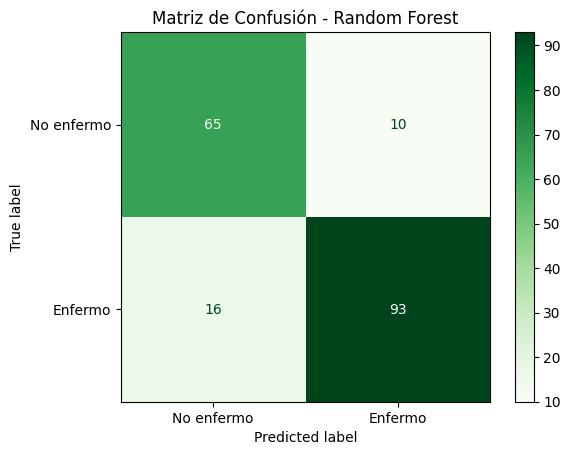

In [ ]:
# Matriz de confusión para Random Forest
matriz_rf = confusion_matrix(y_test, y_pred_rf)

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_rf, display_labels=["No enfermo", "Enfermo"])
disp.plot(cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


### Matriz de confusión:

El modelo de Random Forest muestra una mejora en varios aspectos:

- **65 verdaderos negativos**: casos correctamente clasificados como "no enfermos".
- **93 verdaderos positivos**: pacientes enfermos correctamente identificados.
- **10 falsos positivos**: personas sanas clasificadas incorrectamente como enfermas.
- **16 falsos negativos**: personas enfermas no detectadas.

Comparado con la regresión logística, este modelo:

- Reduce los **falsos negativos** (de 23 a 16), lo que es **crítico en contextos clínicos**.
- Mejora ligeramente los verdaderos positivos (de 86 a 93).
- Mantiene una tasa baja de falsos positivos.

Estos datos sugieren que el modelo de Random Forest tiene una **mayor sensibilidad (recall)**, detectando más casos positivos, lo que podría ser preferible en un entorno donde no detectar un caso real puede tener consecuencias serias.

A continuación, vamos a observar sus métricas de evaluación para confirmar si estas mejoras también se reflejan en precisión, recall y F1-score.


In [ ]:
# Generamos el reporte de métricas para Random Forest
reporte_rf = classification_report(y_test, y_pred_rf, target_names=["No enfermo", "Enfermo"])
print("Reporte de clasificación - Random Forest\n")
print(reporte_rf)


Reporte de clasificación - Random Forest

              precision    recall  f1-score   support

  No enfermo       0.80      0.87      0.83        75
     Enfermo       0.90      0.85      0.88       109

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



### Métricas de evaluación: Random Forest

El modelo de Random Forest logró mejorar el rendimiento general respecto a la regresión logística:

- **Accuracy general**: 0.86 (vs. 0.80 en regresión logística).
- **Precision (enfermo)**: 0.90 → predice enfermedad con mucha precisión.
- **Recall (enfermo)**: 0.85 → detecta el 85% de los casos verdaderamente enfermos (mejor que el 79% anterior).
- **F1-score (enfermo)**: 0.88 → excelente equilibrio entre precisión y sensibilidad.

También mejora la clasificación de los casos "no enfermo", con un recall del 87%.

Estas métricas refuerzan lo observado en la matriz de confusión: el modelo de Random Forest es más efectivo en detectar casos positivos y mantiene un buen rendimiento global. Este tipo de comportamiento puede ser especialmente valioso en contextos donde minimizar los falsos negativos es prioritario.

A continuación, vamos a comparar visualmente ambos modelos utilizando la curva ROC.


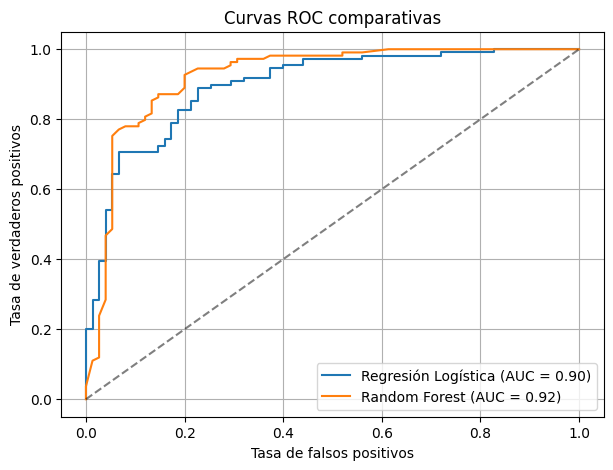

In [ ]:
from sklearn.metrics import roc_curve, auc

# Probabilidades predichas para la clase positiva
y_score_log = modelo_logistico.predict_proba(X_test)[:, 1]
y_score_rf = modelo_rf.predict_proba(X_test)[:, 1]

# Curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)

# Áreas bajo la curva (AUC)
auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)

# Gráfico comparativo
plt.figure(figsize=(7, 5))
plt.plot(fpr_log, tpr_log, label=f'Regresión Logística (AUC = {auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC comparativas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Comparación visual: Curvas ROC

La curva ROC muestra la relación entre la **tasa de verdaderos positivos** (recall) y la **tasa de falsos positivos** para distintos umbrales de decisión. Cuanto más cerca del vértice superior izquierdo esté la curva, mejor es el modelo.

En el gráfico observamos:

- **Regresión Logística**: AUC = 0.90
- **Random Forest**: AUC = 0.92

Ambos modelos tienen una excelente capacidad de discriminación. Sin embargo, Random Forest presenta una curva ligeramente más pronunciada y un área bajo la curva (AUC) superior, lo que confirma su mejor desempeño en este conjunto de datos.

Este análisis visual complementa las métricas numéricas vistas anteriormente y refuerza la elección de Random Forest como el modelo más adecuado para este caso.


In [ ]:
# Recalculamos las métricas clave para cada modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Regresión logística
metrics_log = {
    "Modelo": "Regresión Logística",
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1-Score": f1_score(y_test, y_pred_log),
    "AUC": auc_log
}

# Random Forest
metrics_rf = {
    "Modelo": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-Score": f1_score(y_test, y_pred_rf),
    "AUC": auc_rf
}

# Crear DataFrame comparativo
tabla_resultados = pd.DataFrame([metrics_log, metrics_rf])
tabla_resultados.set_index("Modelo", inplace=True)
tabla_resultados.round(3)  # redondeamos para mejor visualización


,Accuracy,Precision,Recall,F1-Score,AUC
Modelo,,,,,
Regresión Logística,0.804,0.869,0.789,0.827,0.897
Random Forest,0.859,0.903,0.853,0.877,0.922


## Análisis final y cierre


La comparación de métricas entre los modelos entrenados muestra de forma clara que el algoritmo de **Random Forest** logró un mejor rendimiento global que la regresión logística. Supera en todas las métricas clave: `precisión`, `recall`, `F1-score` y `AUC`, lo que indica una mayor capacidad para identificar correctamente tanto los casos positivos como negativos.

Aun así, es importante destacar que la regresión logística también ofreció buenos resultados, con la ventaja de ser un modelo más simple e interpretable. Esta experiencia demuestra que **no existe un único modelo “correcto”**, sino que la elección depende del contexto, de los criterios de evaluación y del equilibrio entre precisión y explicabilidad.

Con esta entrega damos por finalizado el proyecto. A lo largo del proceso:

- Realizamos un análisis exploratorio y limpieza de datos.
- Implementamos un pipeline de preprocesamiento.
- Entrenamos, evaluamos y comparamos modelos con métricas y visualizaciones.
- Reflexionamos sobre el proceso de toma de decisiones con datos reales.

> Lo trabajado aquí constituye una base que podrás adaptar y reutilizar en tus proyectos.